In [158]:
import pandas as pd
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import numpy as np
from docx import Document
from docx.shared import Inches

In [142]:
def get_data(filename):
    try:
        localities = pd.read_excel('localities.xlsx')
        request_data = localities[['cityName','localityId']].to_dict('records')
        api_key = os.environ['API_KEY']
        url = "https://weatherunion.com/gw/weather/external/v0/get_locality_weather_data"
        headers = {
            "Content-Type": "application/json",
            "x-zomato-api-key": api_key
        }
        weather_data = []
        for req_data in request_data:
            params = {"locality_id": req_data['localityId']}
            response = requests.get(url, headers=headers, params=params)
            if response.status_code == 200:
                data = response.json()
                if data['message']=='':
                    data['locality_weather_data']['cityName'] = req_data['cityName']
                    data['locality_weather_data']['localityId'] = req_data['localityId']
                    weather_data.append(data['locality_weather_data'])
            else:
                print("Failed to retrieve data. Status code:", response.status_code)
                print("Response:", response.text)
        df = pd.DataFrame(weather_data)
        df.to_excel(filename)
    except Exception as e:
        print(e)

In [143]:
def generate_insights(df, weather_variable):
    insights = ""
    
    if weather_variable in df.columns:
        city_stats = df.groupby('cityName')[weather_variable].agg(['mean', 'min', 'max'])
        
        highest_avg_city = city_stats['mean'].idxmax()
        highest_avg_value = city_stats.loc[highest_avg_city, 'mean']
        
        lowest_avg_city = city_stats['mean'].idxmin()
        lowest_avg_value = city_stats.loc[lowest_avg_city, 'mean']
        
        common_range_min = np.max([city_stats['min'].min(), city_stats['mean'].min()])
        common_range_max = np.min([city_stats['max'].max(), city_stats['mean'].max()])
        
        insights = f"\nFor {weather_variable}, {highest_avg_city} has the highest average ({highest_avg_value:.2f}), "\
                   f"while {lowest_avg_city} has the lowest average ({lowest_avg_value:.2f}). "\
                   f"The common range across cities is from {common_range_min:.2f} to {common_range_max:.2f}.\n"
    
    return insights

In [144]:
def make_bar_chart(x,y,x_label,y_label,title):
    plt.figure(figsize=(10, 6))
    plt.bar(x,y, color=['blue', 'green', 'red'])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45) 
    plt.tight_layout() 
    filename = f'{title}.png'
    plt.savefig(filename)

In [159]:
def make_correlation(df,title):
    corr_matrix = df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.savefig(f'{title}.png')
    
    high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
    high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]  # Remove self-correlation (diagonal)
    high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.7]

    insights = ""
    seen_pairs = set()
    if not high_corr_pairs.empty:
        insights += "\nHigh correlations:\n"
        for (var1, var2), corr_value in high_corr_pairs.items():
            if (var1, var2) not in seen_pairs and (var2, var1) not in seen_pairs:
                insights += f"- {var1} and {var2} have a correlation of {corr_value:.2f}\n"
                seen_pairs.add((var1, var2))
    else:
        insights += "No high correlations found.\n"

    low_corr_pairs = corr_matrix.abs().unstack().sort_values()
    low_corr_pairs = low_corr_pairs[low_corr_pairs > 0] 
    low_corr_pairs = low_corr_pairs[low_corr_pairs < 0.3]

    seen_pairs = set()
    if not low_corr_pairs.empty:
        insights += "\nLow correlations:\n"
        for (var1, var2), corr_value in low_corr_pairs.items():
            if (var1, var2) not in seen_pairs and (var2, var1) not in seen_pairs:
                insights += f"- {var1} and {var2} have a correlation of {corr_value:.2f}\n"
                seen_pairs.add((var1, var2))
    else:
        insights += "No low correlations found.\n"
    return insights

In [146]:
def degrees_to_direction(degrees):
    directions = ['North', 'North-East', 'East', 'South-East', 'South', 'South-West', 'West', 'North-West']
    index = round(degrees / 45) % 8
    return directions[index]

In [147]:
def generate_wind_direction_insights(df):
    insights = ""
    if 'wind_direction' in df.columns:
        city_stats = df.groupby('cityName')['wind_direction'].apply(lambda x: np.mean(x))
        
        insights = "\n"
        for city, avg_direction in city_stats.items():
            direction_name = degrees_to_direction(avg_direction)
            insights += f"{city}: Dominant wind direction is {direction_name} ({avg_direction:.2f} degrees).\n"
    else:
        insights = "Wind direction data not found in the dataset."
    
    return insights

In [161]:
def make_windrose(city_data,title):
    ax = WindroseAxes.from_ax()
    ax.bar(city_data['wind_direction'], city_data['wind_speed'], normed=True, opening=0.8, edgecolor='white')
    ax.set_title(title)
    plt.savefig(f'{title}.png')

In [169]:
def make_scatter_plots(df,var):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=var, y='cityName', hue='cityName', data=df)
    plt.title(f'Scatter Plot of {var} by City')
    plt.xlabel(var)
    plt.ylabel('City')
    plt.legend(title='City')
    plt.tight_layout()
    plt.savefig(f'Scatter Plot Matrix of {var}.png')

In [170]:
def analyze_weather(filename):
    doc = Document()
    doc.add_heading('Weather Data Analysis', 0)

    df = pd.read_excel(filename)
    cities = list(df['cityName'].unique())
    categories = ['temperature', 'humidity', 'wind_speed', 'wind_direction','rain_intensity', 'rain_accumulation']

    valuable_cities = ['Delhi NCR','Kolkata','Mumbai','Bengaluru','Pune','Hyderabad','Chennai']
    df_val = df[df['cityName'].isin(valuable_cities)]
    df_val = df_val.drop(columns = ['Unnamed: 0'])

    mean_data = max_data = min_data = {}
    for city in cities:
        for category in categories:
            mean_value = df.loc[df['cityName']==city,category].mean()
            max_value = df.loc[df['cityName']==city,category].max()
            min_value = df.loc[df['cityName']==city,category].min()
            if category not in mean_data: 
                mean_data[category] = {}
            if category not in max_data: 
                max_data[category] = {}
            if category not in min_data: 
                min_data[category] = {}
            mean_data[category][city] = mean_value
            max_data[category][city] = max_value
            min_data[category][city] = min_value
            
    mean_data = pd.DataFrame(mean_data).fillna(0)
    max_data = pd.DataFrame(mean_data)
    min_data = pd.DataFrame(mean_data)
    
    doc.add_heading(f'Weather Variables Data Analysis', level=1)
    for category in categories:
        make_bar_chart(x = cities,y = mean_data[category],x_label = 'Cities',y_label = f'Mean {category}',title = f'Mean {category} of Cities')
        make_bar_chart(x = cities,y = max_data[category],x_label = 'Cities',y_label = f'Max {category}',title = f'Max {category} of Cities')
        make_bar_chart(x = cities,y = min_data[category],x_label = 'Cities',y_label = f'Min {category}',title = f'Min {category} of Cities')
        doc.add_heading(f'{category} Data Analysis', level=2)
        doc.add_picture(f'Mean {category} of Cities.png', width=Inches(6))
        doc.add_picture(f'Max {category} of Cities.png', width=Inches(6))
        doc.add_picture(f'Min {category} of Cities.png', width=Inches(6))
        insights = generate_insights(df_val, category)
        make_scatter_plots(df_val,category)
        doc.add_picture(f'Scatter Plot Matrix of {category}.png', width=Inches(6))
        doc.add_paragraph(insights)

    
    insights = make_correlation(df_val[categories],title = 'Correlation Matrix of Weather Variables')
    doc.add_heading(f'Correlation Analysis of Weather Variables', level=1)
    doc.add_picture('Correlation Matrix of Weather Variables.png', width=Inches(6))
    doc.add_paragraph(insights)
    
    doc.add_heading(f'Wind Direction Analysis', level=1)
    for city in valuable_cities:
        city_data = df[df['cityName'] == city]
        make_windrose(city_data = city_data, title = f'Wind Rose Diagram for {city}')
        doc.add_heading(f'Wind Rose Diagram for {city}', level=2)
        doc.add_picture(f'Wind Rose Diagram for {city}.png', width=Inches(6))
    insights = generate_wind_direction_insights(df_val)
    doc.add_paragraph(insights)
    
    
    doc.save('Weather_Data_Analysis.docx')

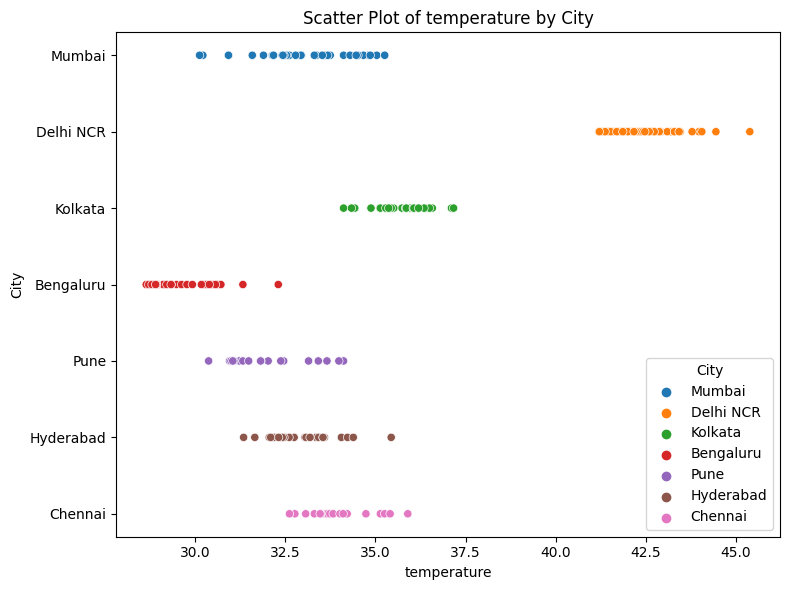

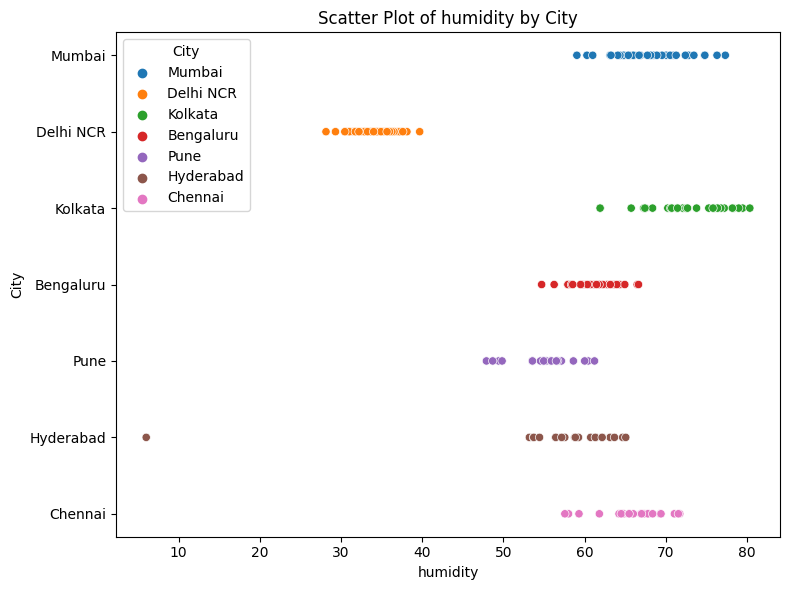

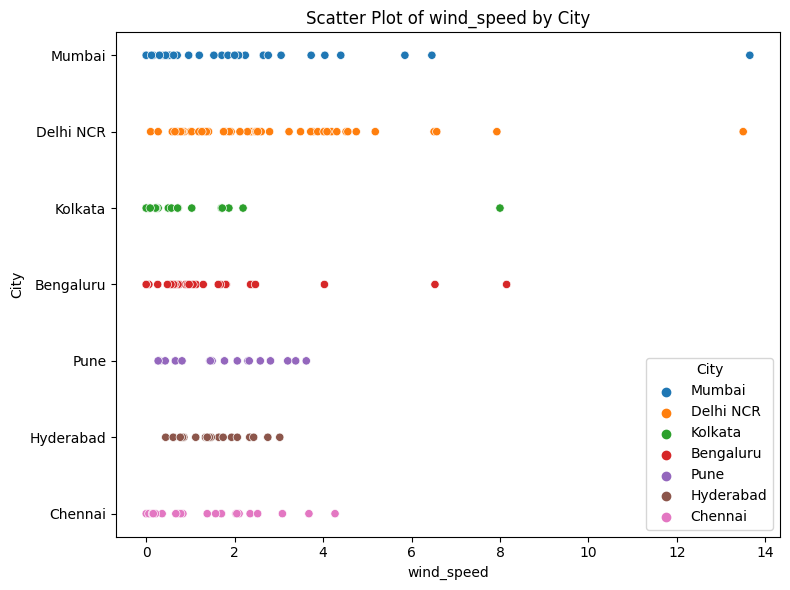

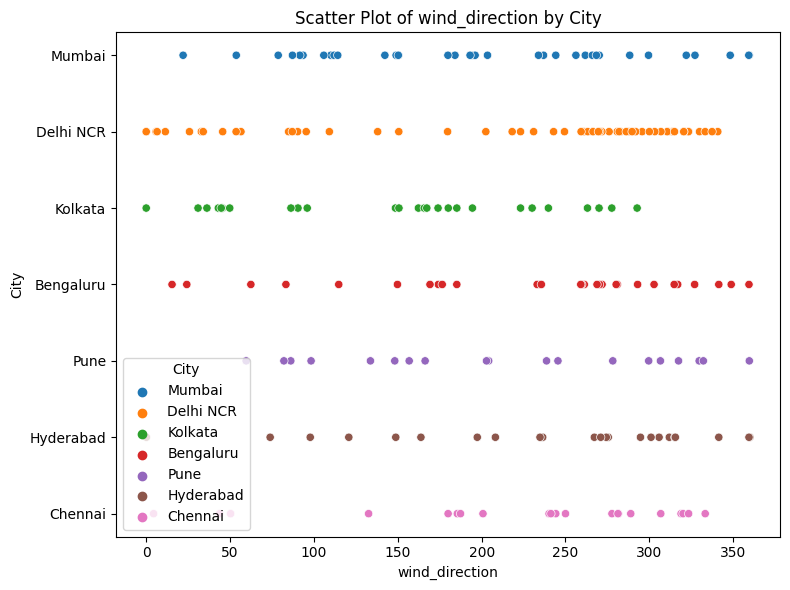

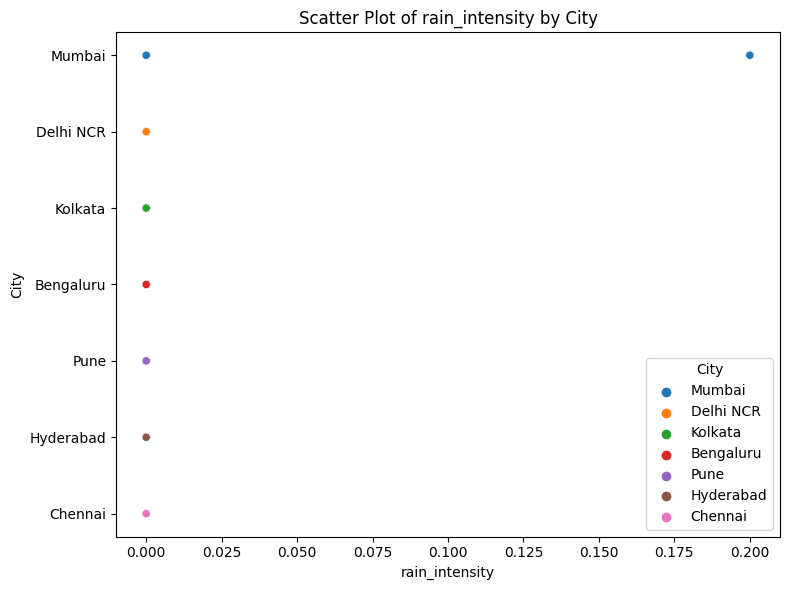

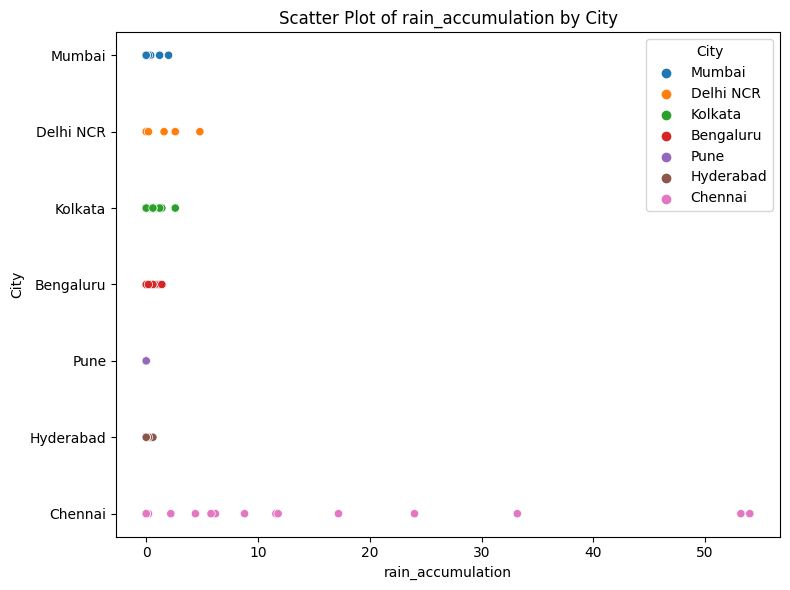

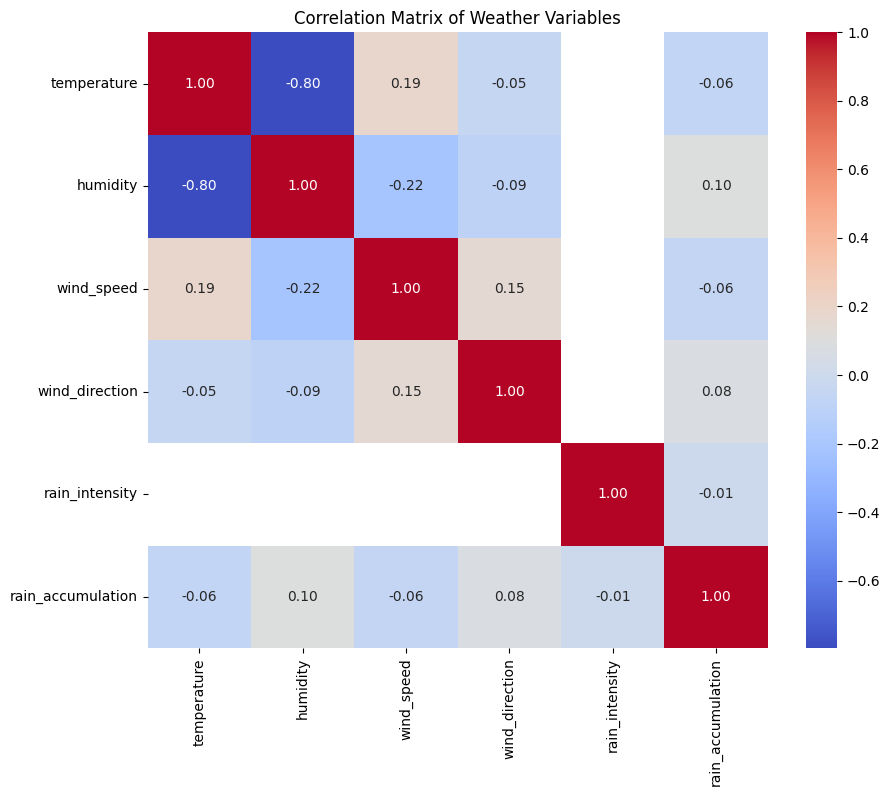

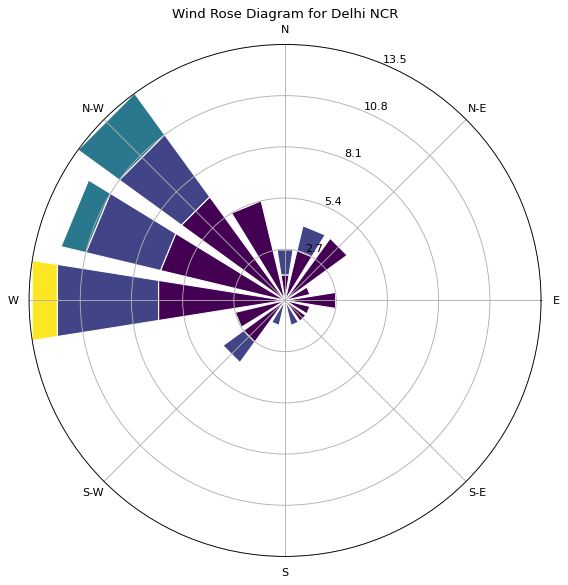

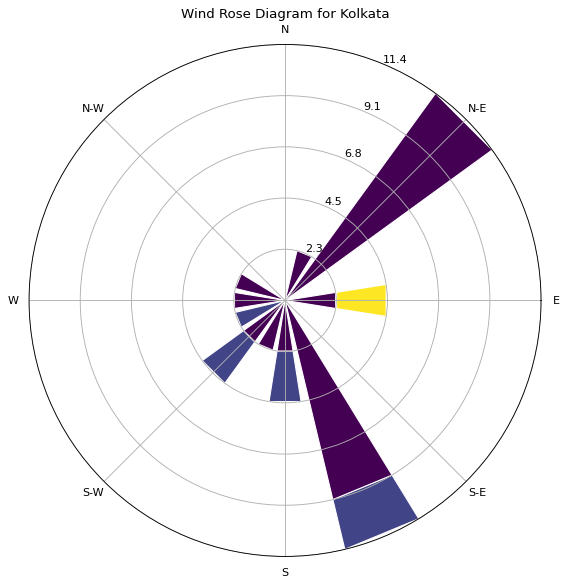

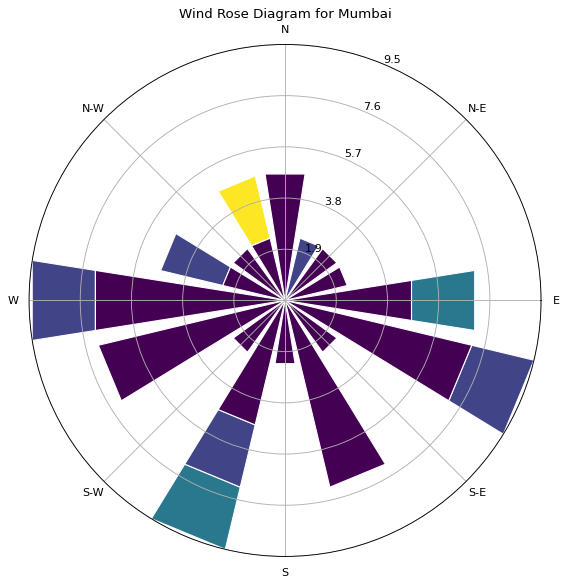

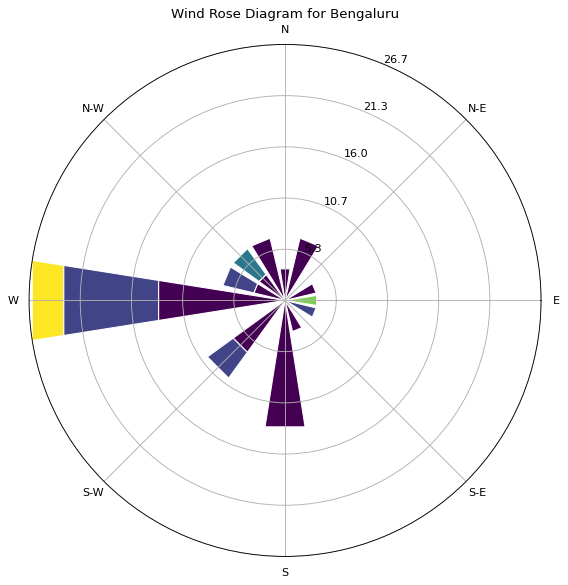

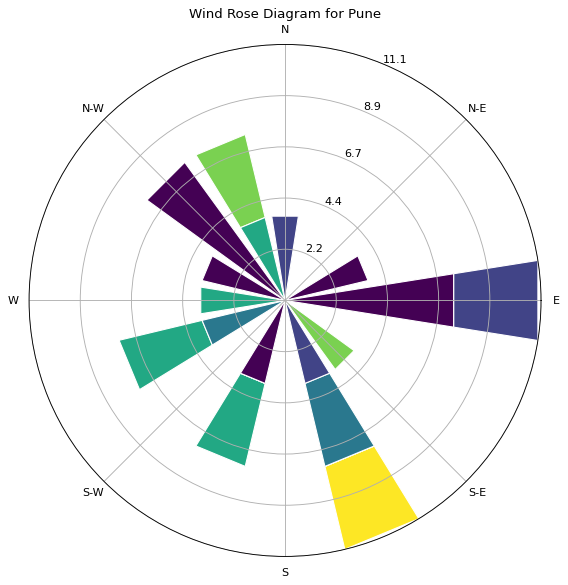

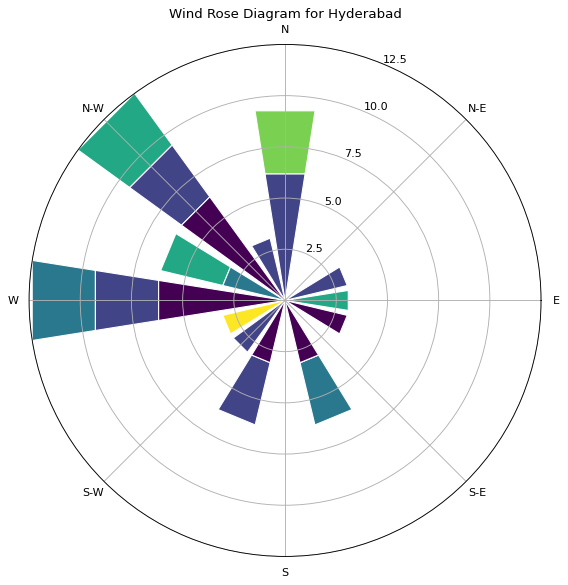

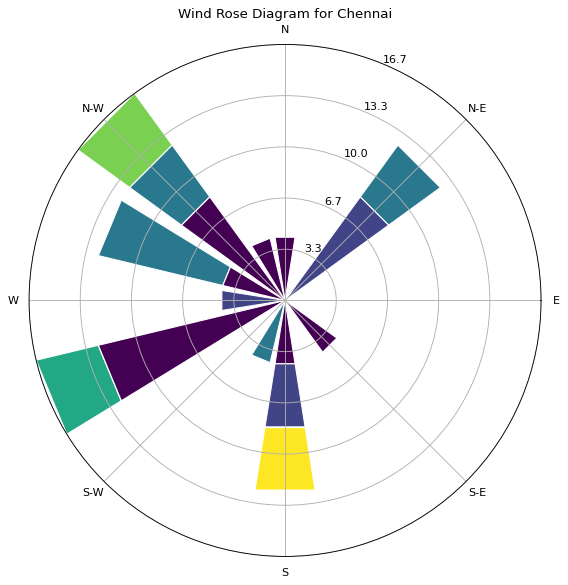

In [171]:
get_data('output.xlsx')
analyze_weather('output.xlsx')